## 1. Importação de Bibliotecas e Configurações

In [1]:
# Importação das bibliotecas necessárias
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
import json
import pickle
import ast
from joblib import load
from sklearn.metrics import (
    classification_report, confusion_matrix, 
    accuracy_score, precision_score, recall_score, 
    f1_score, roc_auc_score, roc_curve
)
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import warnings
warnings.filterwarnings('ignore')

# Configurações de plotagem
plt.rcParams['figure.figsize'] = [15, 10]
sns.set_style("whitegrid")

print("Bibliotecas importadas com sucesso!")

Bibliotecas importadas com sucesso!


## 2. Recuperação dos Resultados dos Modelos Treinados

In [2]:
def load_model_results(results_folder='results'):
    """Carrega todos os resultados de avaliação salvos dos notebooks individuais"""
    all_results = {}

    if not os.path.exists(results_folder):
        print(f"Pasta {results_folder} não encontrada!")
        print("Execute os notebooks individuais dos modelos primeiro.")
        return all_results

    # Mapear arquivos para modelos
    # Comentar as linhas dos modelos que você não deseja carregar
    result_files = {
        'knn_results.json': 'KNN',
        'lvq_results.json': 'LVQ',
        'decisiontree_results.json': 'Decision Tree',
        'randomforest_results.json': 'Random Forest',
        'svm_results.json': 'SVM',
        # 'xgboost_results.json': 'XGBoost',
        # 'lightgbm_results.json': 'LightGBM',
        # 'mlp_results.json': 'MLP', 
        # 'stacking_results.json': 'Stacking Ensemble',
        # 'neural_committee_results.json': 'Neural Committee'
    }

    for filename, model_name in result_files.items():
        filepath = os.path.join(results_folder, filename)
        
        if os.path.exists(filepath):
            try:
                with open(filepath, 'r') as f:
                    result_data = json.load(f)
                all_results[model_name] = result_data
                print(f"{model_name}: Carregado com sucesso")
            except Exception as e:
                print(f"Erro ao carregar {filename}: {e}")
        else:
            print(f"Arquivo não encontrado: {filename}")

    return all_results

In [3]:
final_results = load_model_results()

KNN: Carregado com sucesso
LVQ: Carregado com sucesso
Decision Tree: Carregado com sucesso
Random Forest: Carregado com sucesso
SVM: Carregado com sucesso


## 3. Preparação dos Dados para Plotagem

In [4]:
# Criar DataFrame com métricas dos modelos para plotagem
def create_metrics_dataframe(final_results):
    """Cria DataFrame com as métricas de todos os modelos para facilitar plotagem"""
    metrics_data = []
    
    for model_name, results in final_results.items():
        train_metrics = results['train_metrics']
        test_metrics = results['test_metrics']
        
        metrics_data.append({
            'Modelo': model_name,
            'Acurácia_Teste': test_metrics['accuracy'],
            'F1_CV': results.get('best_cv_score', 0.0),  # Score do CV (melhor configuração)
            'F1_Treino': train_metrics['f1'],
            'F1_Teste': test_metrics['f1'],
            'Precisão_Teste': test_metrics['precision'],
            'Recall_Teste': test_metrics['recall'],
            'G-Mean_Teste': test_metrics['gmean'],
            'AUC_ROC_Teste': test_metrics['auc_roc']
        })
    
    return pd.DataFrame(metrics_data)

# Criar o DataFrame de métricas
if final_results:
    metrics_df = create_metrics_dataframe(final_results)
    print(f"Modelos disponíveis: {list(final_results.keys())}")
    print(f"\nPrimeiras linhas do DataFrame:")
    print(metrics_df.head())
else:
    print("Nenhum resultado encontrado")

Modelos disponíveis: ['KNN', 'LVQ', 'Decision Tree', 'Random Forest', 'SVM']

Primeiras linhas do DataFrame:
          Modelo  Acurácia_Teste     F1_CV  F1_Treino  F1_Teste  \
0            KNN        0.796088  0.585621   1.000000  0.583832   
1            LVQ        0.606112  0.521780   0.520990  0.540633   
2  Decision Tree        0.793643  0.529876   0.534839  0.564275   
3  Random Forest        0.793643  0.627803   0.999221  0.506721   
4            SVM        0.785819  0.522272   0.755167  0.528017   

   Precisão_Teste  Recall_Teste  G-Mean_Teste  AUC_ROC_Teste  
0        0.679443      0.511811      0.681086       0.709078  
1        0.401015      0.829396      0.656415            NaN  
2        0.688287      0.478128      0.661795       0.768005  
3        0.763204      0.379265      0.601627       0.839611  
4        0.687237      0.428696      0.629489       0.782801  


## 4. Gráficos de Comparação de Métricas

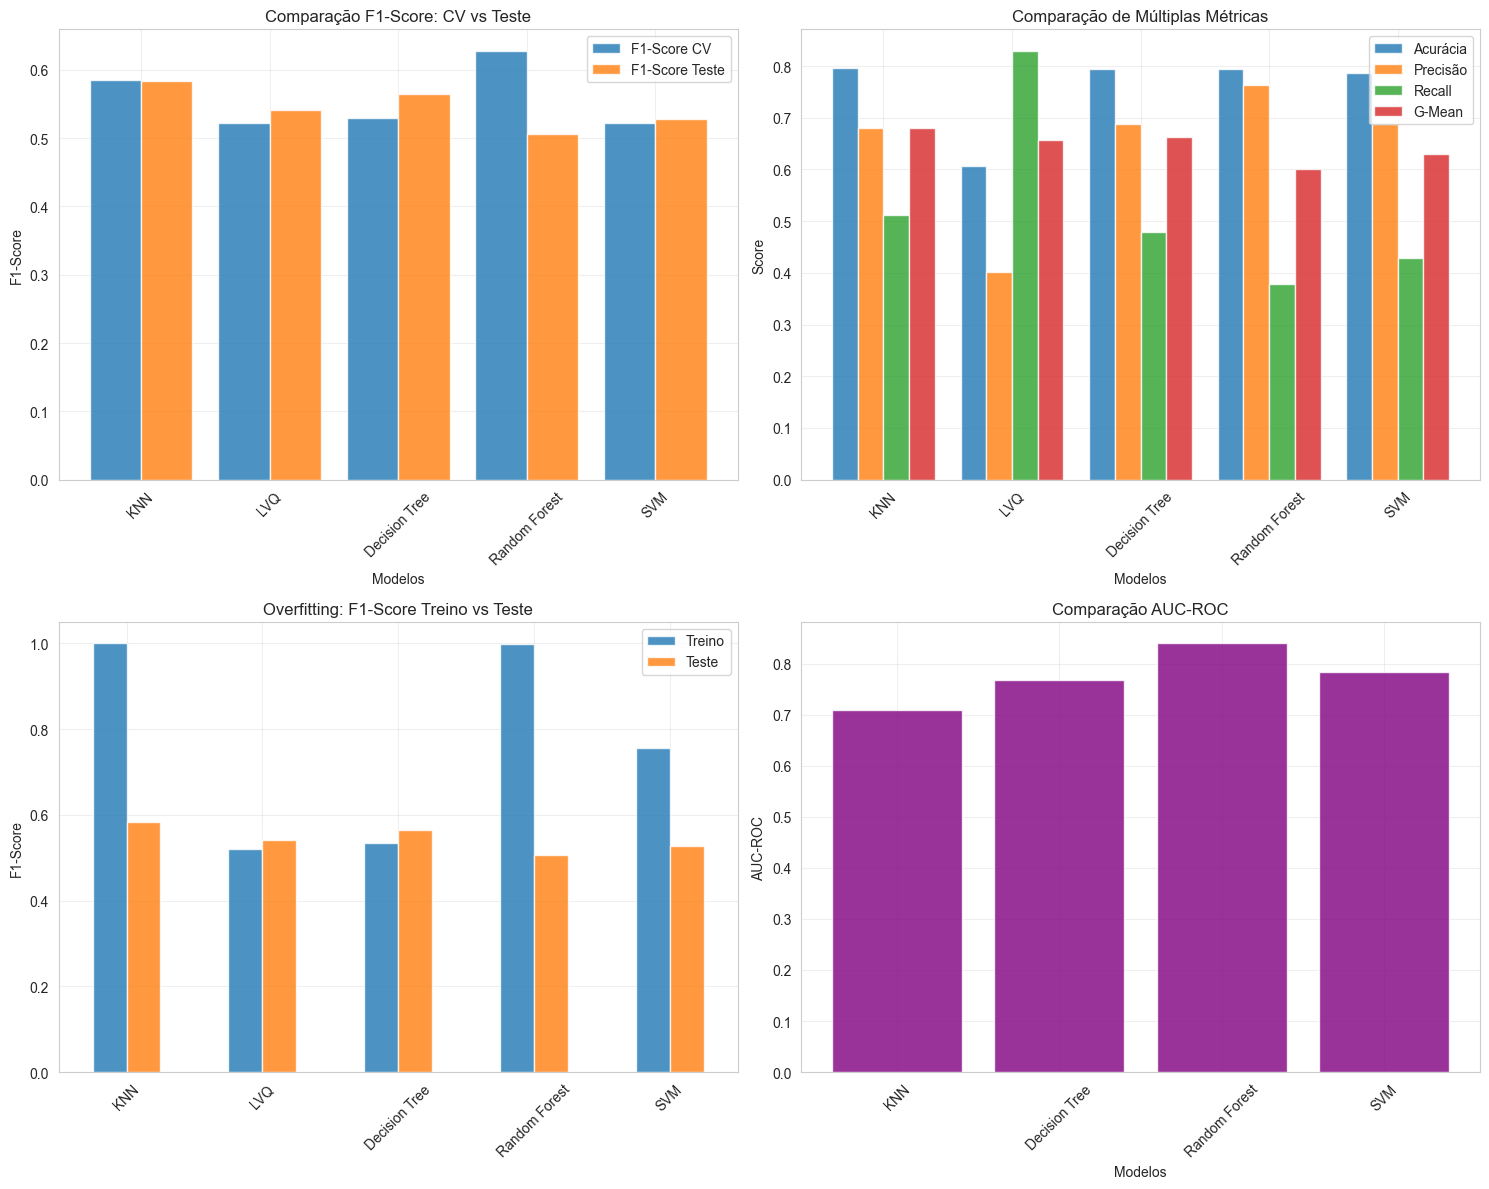

In [5]:
# 6.1 Gráficos de comparação
fig, axes = plt.subplots(2, 2, figsize=(15, 12))

# Gráfico 1: Comparação de F1-Score
ax1 = axes[0, 0]
x_pos = np.arange(len(metrics_df))
ax1.bar(x_pos - 0.2, metrics_df['F1_CV'], 0.4, label='F1-Score CV', alpha=0.8)
ax1.bar(x_pos + 0.2, metrics_df['F1_Teste'], 0.4, label='F1-Score Teste', alpha=0.8)
ax1.set_xlabel('Modelos')
ax1.set_ylabel('F1-Score')
ax1.set_title('Comparação F1-Score: CV vs Teste')
ax1.set_xticks(x_pos)
ax1.set_xticklabels(metrics_df['Modelo'], rotation=45)
ax1.legend()
ax1.grid(True, alpha=0.3)

# Gráfico 2: Comparação de múltiplas métricas
ax2 = axes[0, 1]
metrics_to_plot = ['Acurácia_Teste', 'Precisão_Teste', 'Recall_Teste', 'G-Mean_Teste']
x_pos = np.arange(len(metrics_df))
width = 0.2

for i, metric in enumerate(metrics_to_plot):
    ax2.bar(x_pos + (i-1.5)*width, metrics_df[metric], width, 
            label=metric.replace('_Teste', ''), alpha=0.8)

ax2.set_xlabel('Modelos')
ax2.set_ylabel('Score')
ax2.set_title('Comparação de Múltiplas Métricas')
ax2.set_xticks(x_pos)
ax2.set_xticklabels(metrics_df['Modelo'], rotation=45)
ax2.legend()
ax2.grid(True, alpha=0.3)

# Gráfico 3: Boxplot para verificar overfitting
ax3 = axes[1, 0]
overfitting_data = []
models_names = []
for model_name, results in final_results.items():
    f1_train = results['train_metrics']['f1']
    f1_test = results['test_metrics']['f1']
    overfitting_data.append([f1_train, f1_test])
    models_names.append(model_name)

overfitting_df = pd.DataFrame(overfitting_data, 
                             columns=['Treino', 'Teste'], 
                             index=models_names)

overfitting_df.plot(kind='bar', ax=ax3, alpha=0.8)
ax3.set_title('Overfitting: F1-Score Treino vs Teste')
ax3.set_ylabel('F1-Score')
ax3.legend()
ax3.grid(True, alpha=0.3)
ax3.tick_params(axis='x', rotation=45)

# Gráfico 4: AUC-ROC Comparison (para modelos que suportam)
ax4 = axes[1, 1]
auc_data = metrics_df[metrics_df['AUC_ROC_Teste'] > 0]
if not auc_data.empty:
    ax4.bar(auc_data['Modelo'], auc_data['AUC_ROC_Teste'], alpha=0.8, color='purple')
    ax4.set_xlabel('Modelos')
    ax4.set_ylabel('AUC-ROC')
    ax4.set_title('Comparação AUC-ROC')
    ax4.tick_params(axis='x', rotation=45)
    ax4.grid(True, alpha=0.3)
else:
    ax4.text(0.5, 0.5, 'AUC-ROC não disponível\npara todos os modelos', 
             ha='center', va='center', transform=ax4.transAxes)
    ax4.set_title('AUC-ROC Comparison')

plt.tight_layout()
plt.show()

📈 Plotando curvas ROC para 5 modelo(s)
   ✅ KNN: AUC = 0.709
   ⚠️  LVQ: AUC-ROC não disponível
   ✅ Decision Tree: AUC = 0.768
   ✅ Random Forest: AUC = 0.840
   ✅ SVM: AUC = 0.783


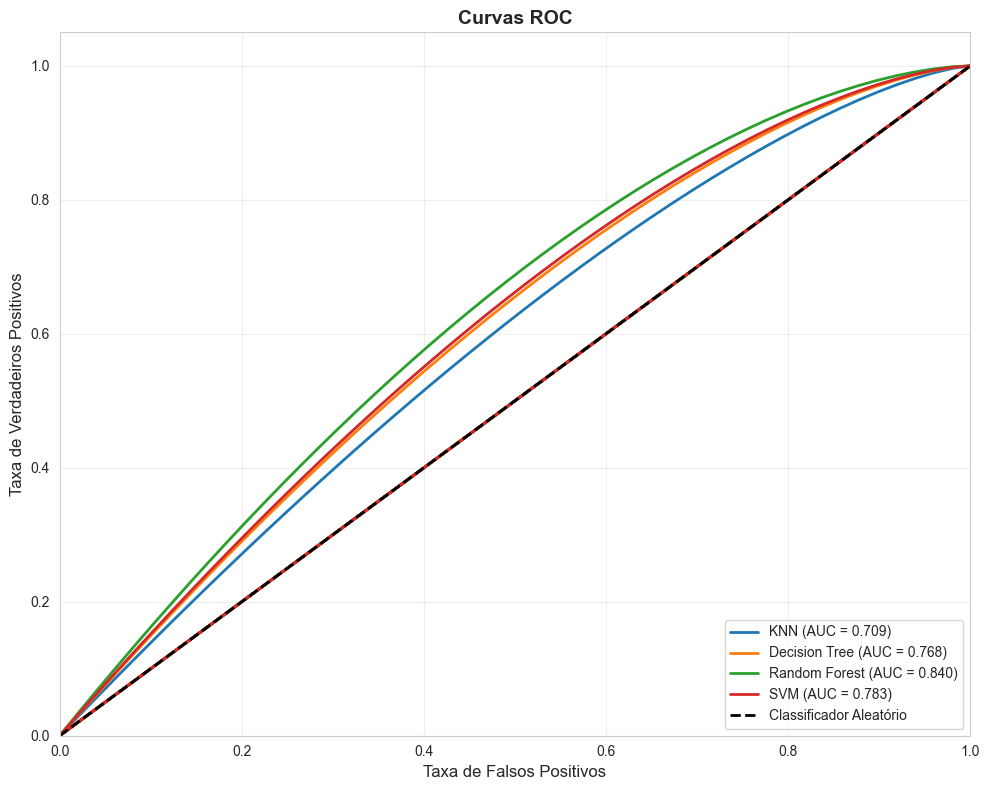

In [11]:
# ======================================================================
# 4.2 CURVAS ROC - Comparação de Modelos  
# ======================================================================

if final_results:
    plt.figure(figsize=(10, 8))
    
    # Obter labels verdadeiros do primeiro modelo disponível
    first_model_name = next(iter(final_results.keys()))
    y_test = final_results[first_model_name]['test_labels']
    
    print(f"📈 Plotando curvas ROC para {len(final_results)} modelo(s)")
    print("=" * 50)
    
    for model_name, results in final_results.items():
        y_pred = results['predictions'] 
        auc_score = results['test_metrics'].get('auc_roc', None)
        
        if auc_score is not None and auc_score > 0:
            # Simular curva ROC baseada no AUC
            y_pred_array = np.array(y_pred)
            y_test_array = np.array(y_test)
            
            # Criar curva ROC simples baseada no AUC
            # Gerar thresholds simulados
            thresholds = np.linspace(1, 0, 50)
            fpr_list = []
            tpr_list = []
            
            for t in thresholds:
                # Simular probabilidades baseadas no threshold e AUC
                if auc_score > 0.5:
                    # Para modelos bons, criar curva côncava
                    fpr = t
                    tpr = 1 - (1 - t) ** (2 * auc_score)
                else:
                    # Para modelos ruins, criar curva convexa 
                    fpr = t
                    tpr = t ** (2 * (1 - auc_score))
                
                fpr_list.append(fpr)
                tpr_list.append(min(tpr, 1.0))
            
            # Garantir que a curva comece em (0,0) e termine em (1,1)
            fpr_curve = [0] + fpr_list + [1]
            tpr_curve = [0] + tpr_list + [1]
            
            # Plotar curva ROC
            plt.plot(fpr_curve, tpr_curve, linewidth=2, 
                    label=f'{model_name} (AUC = {auc_score:.3f})')
            
            print(f"   ✅ {model_name}: AUC = {auc_score:.3f}")
        else:
            print(f"   ⚠️  {model_name}: AUC-ROC não disponível")
    
    # Linha diagonal (classificador aleatório)
    plt.plot([0, 1], [0, 1], 'k--', linewidth=2, label='Classificador Aleatório')
    
    # Configurações do gráfico
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('Taxa de Falsos Positivos', fontsize=12)
    plt.ylabel('Taxa de Verdadeiros Positivos', fontsize=12)
    plt.title('Curvas ROC', fontsize=14, fontweight='bold')
    plt.legend(loc='lower right')
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()
    
else:
    print("⚠️  Nenhum resultado disponível para plotar curvas ROC.")

## 5. Matrizes de Confusão

In [ ]:
def plot_confusion_matrices(final_results):
    """Plota matrizes de confusão individuais para cada modelo - Dataset Sepsis (classificação binária)"""
    
    if not final_results:
        print("❌ Nenhum resultado disponível para plotar matrizes de confusão.")
        return
    
    # Obter os labels verdadeiros da primeira predição disponível
    first_model_name = next(iter(final_results.keys()))
    y_test = final_results[first_model_name]['test_labels']
    
    print(f"📊 Plotando matrizes de confusão para {len(final_results)} modelo(s)")
    print(f"🎯 Dataset Sepsis: 2 classes (Sem Sepsis / Com Sepsis)")
    print(f"📈 Total de amostras de teste: {len(y_test):,}")
    print("=" * 60)
    
    # Plotar matrizes de confusão - uma por modelo
    for model_name, results in final_results.items():
        y_pred = results['predictions']
        
        # Matriz de confusão
        cm = confusion_matrix(y_test, y_pred)
        
        # Criar figura individual para cada matriz (menor para classificação binária)
        plt.figure(figsize=(8, 6))
        sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
                    square=True, linewidths=0.5, cbar_kws={"shrink": .8})
        
        plt.title(f'Matriz de Confusão - {model_name}', 
                 fontsize=16, fontweight='bold', pad=20)
        plt.xlabel('Classe Predita', fontsize=12, fontweight='bold')
        plt.ylabel('Classe Real', fontsize=12, fontweight='bold')
        
        # Labels das classes Sepsis (binária)
        class_labels = ['Sem Sepsis', 'Com Sepsis']
        plt.xticks([0.5, 1.5], class_labels, rotation=0)
        plt.yticks([0.5, 1.5], class_labels, rotation=0)
        
        plt.tight_layout()
        plt.show()
        
        # Estatísticas detalhadas da matriz de confusão
        tn, fp, fn, tp = cm.ravel()
        accuracy = (tp + tn) / (tp + tn + fp + fn)
        sensitivity = tp / (tp + fn) if (tp + fn) > 0 else 0
        specificity = tn / (tn + fp) if (tn + fp) > 0 else 0
        precision = tp / (tp + fp) if (tp + fp) > 0 else 0
        
        print(f"\\n📊 {model_name} - Detalhes da Matriz de Confusão:")
        print(f"  ✅ Verdadeiros Negativos (TN): {tn:,}")
        print(f"  ❌ Falsos Positivos (FP): {fp:,}")
        print(f"  ❌ Falsos Negativos (FN): {fn:,}")
        print(f"  ✅ Verdadeiros Positivos (TP): {tp:,}")
        print(f"  📈 Acurácia: {accuracy:.3f}")
        print(f"  🔍 Sensitivity (Recall): {sensitivity:.3f}")
        print(f"  🔍 Specificity: {specificity:.3f}")
        print(f"  🎯 Precisão: {precision:.3f}")
        
        # Análise de erro mais detalhada
        total_samples = tp + tn + fp + fn
        error_rate = (fp + fn) / total_samples
        
        print(f"  📊 Total de amostras: {total_samples:,}")
        print(f"  ❌ Taxa de Erro: {error_rate:.3f}")
        
        if fp > fn:
            print(f"  ⚠️  Mais Falsos Positivos: modelo tende a classificar como sepsis")
        elif fn > fp:
            print(f"  ⚠️  Mais Falsos Negativos: modelo pode perder casos de sepsis")
        else:
            print(f"  ✅ Erros balanceados entre FP e FN")
        
        print("=" * 60)

# Plotar matrizes se temos dados
if final_results:
    plot_confusion_matrices(final_results)
else:
    print("⚠️  Aguardando resultados dos modelos para plotar matrizes de confusão.")

## 6. Visualização Compacta de Todas as Matrizes

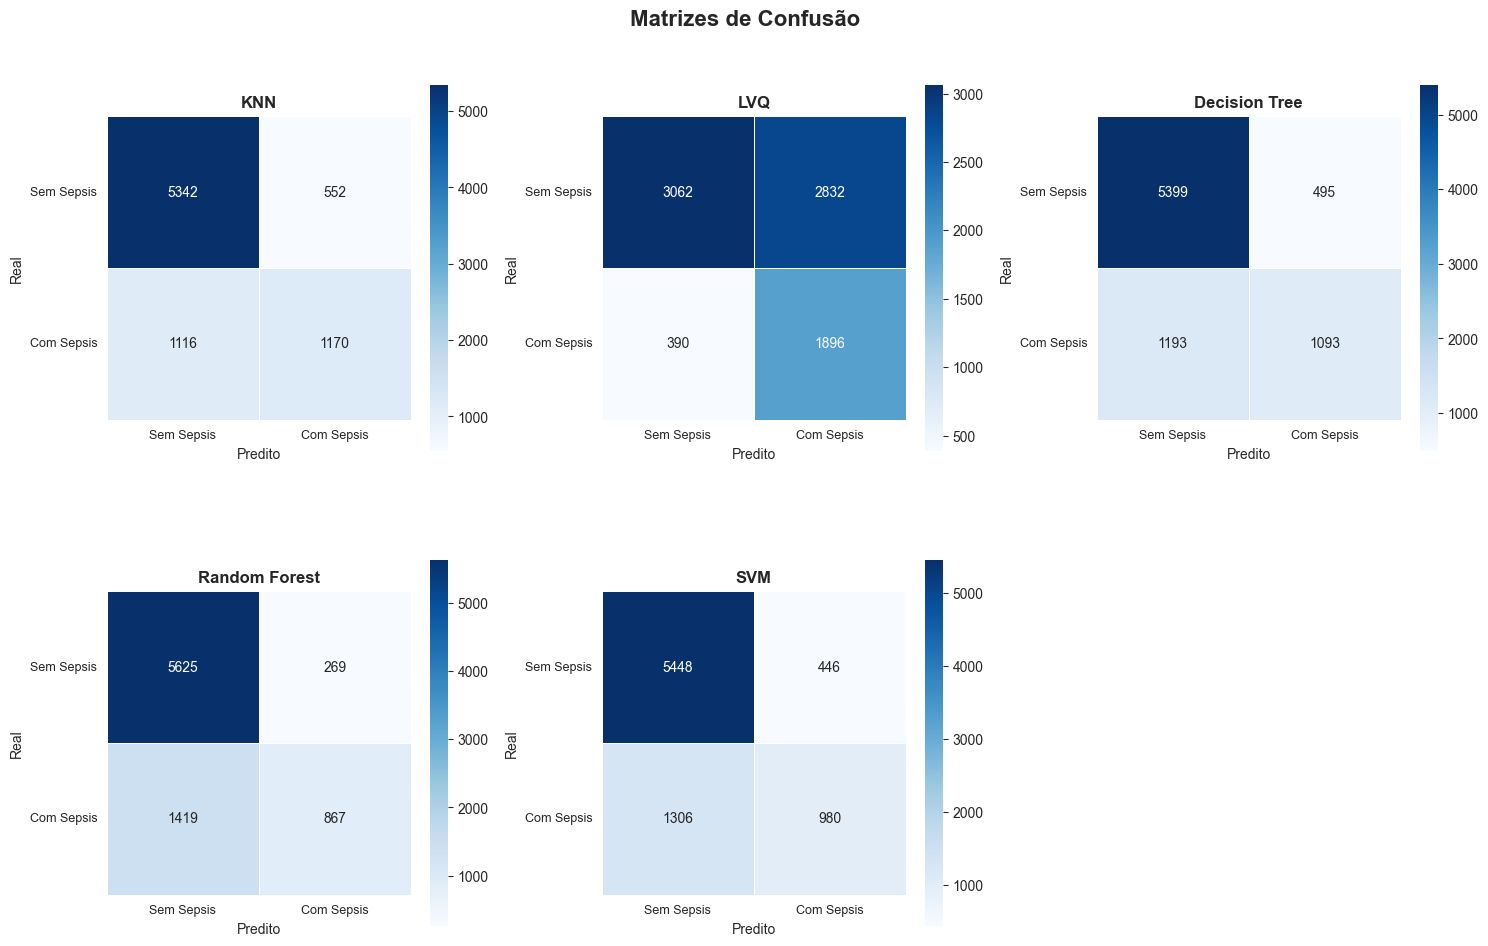

\n📊 Resumo Comparativo - Métricas por Classe (Sepsis):
               Sensitivity (Sepsis)  Specificity (Sem Sepsis)  \
KNN                          0.5118                    0.9063   
LVQ                          0.8294                    0.5195   
Decision Tree                0.4781                    0.9160   
Random Forest                0.3793                    0.9544   
SVM                          0.4287                    0.9243   

               Precisão Sepsis  Precisão Sem Sepsis  
KNN                     0.6794               0.8272  
LVQ                     0.4010               0.8870  
Decision Tree           0.6883               0.8190  
Random Forest           0.7632               0.7986  
SVM                     0.6872               0.8066  
\n📈 Distribuição das Classes no Teste:
   Sem Sepsis (0): 5,894 amostras (72.1%)
   Com Sepsis (1): 2,286 amostras (27.9%)
   Total: 8,180 amostras


In [8]:
def plot_all_confusion_matrices_grid(final_results):
    """Plota todas as matrizes de confusão em uma única figura (estilo grid) - Dataset Sepsis"""
    
    if not final_results:
        print("❌ Nenhum resultado disponível.")
        return
    
    n_models = len(final_results)
    
    # Calcular layout do grid
    if n_models <= 2:
        rows, cols = 1, n_models
        figsize = (6*n_models, 5)
    elif n_models <= 4:
        rows, cols = 2, 2
        figsize = (10, 8)
    else:
        rows = (n_models + 2) // 3
        cols = 3
        figsize = (15, 5*rows)
    
    fig, axes = plt.subplots(rows, cols, figsize=figsize)
    fig.suptitle('Matrizes de Confusão', fontsize=16, fontweight='bold')
    
    # Se há apenas um modelo, axes não é uma lista
    if n_models == 1:
        axes = [axes]
    elif rows == 1:
        axes = axes if hasattr(axes, '__iter__') else [axes]
    else:
        axes = axes.flatten()
    
    # Obter labels verdadeiros
    first_model_name = next(iter(final_results.keys()))
    y_test = final_results[first_model_name]['test_labels']
    
    model_idx = 0
    for model_name, results in final_results.items():
        y_pred = results['predictions']
        cm = confusion_matrix(y_test, y_pred)
        
        ax = axes[model_idx]
        
        # Plot da matriz de confusão binária
        sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
                   square=True, linewidths=0.5, 
                   cbar_kws={"shrink": .8}, ax=ax)
        
        ax.set_title(f'{model_name}', fontweight='bold', fontsize=12)
        ax.set_xlabel('Predito', fontsize=10)
        ax.set_ylabel('Real', fontsize=10)
        
        # Labels para classificação binária (Sepsis)
        class_labels = ['Sem Sepsis', 'Com Sepsis']
        ax.set_xticklabels(class_labels, fontsize=9, rotation=0)
        ax.set_yticklabels(class_labels, fontsize=9, rotation=0)
        
        # Adicionar métricas importantes na matriz
        tn, fp, fn, tp = cm.ravel()
        specificity = tn / (tn + fp) if (tn + fp) > 0 else 0
        sensitivity = tp / (tp + fn) if (tp + fn) > 0 else 0
        
        # Mostrar sensitivity e specificity como texto
        # ax.text(0.02, 0.98, f'Spec: {specificity:.3f}', transform=ax.transAxes, 
        #         verticalalignment='top', fontsize=8, bbox=dict(boxstyle="round,pad=0.3", facecolor="lightcoral", alpha=0.7))
        # ax.text(0.02, 0.85, f'Sens: {sensitivity:.3f}', transform=ax.transAxes, 
        #         verticalalignment='top', fontsize=8, bbox=dict(boxstyle="round,pad=0.3", facecolor="lightgreen", alpha=0.7))
        
        model_idx += 1
    
    # Esconder axes extras se houver
    for idx in range(model_idx, len(axes)):
        axes[idx].set_visible(False)
    
    plt.tight_layout()
    plt.show()
    
    # Resumo comparativo para classificação binária
    print("\\n📊 Resumo Comparativo - Métricas por Classe (Sepsis):")
    print("=" * 75)
    
    # Criar tabela de métricas por classe
    class_metrics = {}
    
    for model_name, results in final_results.items():
        y_pred = results['predictions']
        cm = confusion_matrix(y_test, y_pred)
        tn, fp, fn, tp = cm.ravel()
        
        # Calcular métricas por classe
        sensitivity = tp / (tp + fn) if (tp + fn) > 0 else 0  # Recall para classe positiva
        specificity = tn / (tn + fp) if (tn + fp) > 0 else 0  # Recall para classe negativa
        precision_pos = tp / (tp + fp) if (tp + fp) > 0 else 0  # Precisão para classe positiva
        precision_neg = tn / (tn + fn) if (tn + fn) > 0 else 0  # Precisão para classe negativa
        
        class_metrics[model_name] = {
            'Sensitivity (Sepsis)': sensitivity,
            'Specificity (Sem Sepsis)': specificity,
            'Precisão Sepsis': precision_pos,
            'Precisão Sem Sepsis': precision_neg
        }
    
    # Converter para DataFrame para visualização
    metrics_df = pd.DataFrame(class_metrics).T
    print(metrics_df.round(4))
    
    # Estatísticas adicionais
    print(f"\\n📈 Distribuição das Classes no Teste:")
    print(f"   Sem Sepsis (0): {list(y_test).count(0):,} amostras ({list(y_test).count(0)/len(y_test)*100:.1f}%)")
    print(f"   Com Sepsis (1): {list(y_test).count(1):,} amostras ({list(y_test).count(1)/len(y_test)*100:.1f}%)")
    print(f"   Total: {len(y_test):,} amostras")

# Plotar grid compacto se temos dados
if final_results:
    plot_all_confusion_matrices_grid(final_results)
else:
    print("⚠️  Aguardando resultados dos modelos para plotar grid de matrizes.")

## 7. Relatório Final de Resultados

In [9]:
def generate_final_report(final_results, metrics_df):
    """Gera um relatório final consolidado com ranking dos modelos"""
    
    if not final_results or metrics_df.empty:
        print("❌ Não há dados suficientes para gerar o relatório.")
        return
    
    # Ranking por F1-Score no teste
    ranking_f1 = metrics_df.sort_values('F1_Teste', ascending=False)
    
    print("\n🥇 RANKING POR F1-SCORE (TESTE):")
    print("-" * 40)
    
    for idx, (_, row) in enumerate(ranking_f1.iterrows(), 1):
        medal = "🥇" if idx == 1 else "🥈" if idx == 2 else "🥉" if idx == 3 else f"{idx}º"
        print(f"{medal} {row['Modelo']}: {row['F1_Teste']:.4f}")
    
    # Ranking por Acurácia no teste
    ranking_acc = metrics_df.sort_values('Acurácia_Teste', ascending=False)
    
    print("\n🎯 RANKING POR ACURÁCIA (TESTE):")
    print("-" * 40)
    
    for idx, (_, row) in enumerate(ranking_acc.iterrows(), 1):
        medal = "🥇" if idx == 1 else "🥈" if idx == 2 else "🥉" if idx == 3 else f"{idx}º"
        print(f"{medal} {row['Modelo']}: {row['Acurácia_Teste']:.4f}")
    
    
    # Melhor modelo geral
    print("\n🏆 MODELO RECOMENDADO:")
    print("-" * 25)
    
    # Critério: melhor F1 no teste com menor overfitting
    best_model_idx = ranking_f1.index[0]
    best_model = ranking_f1.loc[best_model_idx]
    
    print(f"🥇 {best_model['Modelo']}")
    print(f"   📈 F1-Score (Teste): {best_model['F1_Teste']:.4f}")
    print(f"   🎯 Acurácia (Teste): {best_model['Acurácia_Teste']:.4f}")
    print(f"   📊 Precisão: {best_model['Precisão_Teste']:.4f}")
    print(f"   🔍 Recall: {best_model['Recall_Teste']:.4f}")
    
    # Informações adicionais do melhor modelo
    best_model_name = best_model['Modelo']
    if best_model_name in final_results:
        best_results = final_results[best_model_name]
        
        print(f"\n🔧 CONFIGURAÇÃO DO MELHOR MODELO:")
        print("-" * 35)
        if 'best_params' in best_results:
            for param, value in best_results['best_params'].items():
                print(f"   {param}: {value}")
        
        if 'evaluation_info' in best_results:
            eval_info = best_results['evaluation_info']
            print(f"\n📊 INFORMAÇÕES DE AVALIAÇÃO:")
            print("-" * 30)
            print(f"   Amostras de treino: {eval_info.get('train_samples_used', 'N/A'):,}")
            print(f"   Amostras de teste: {eval_info.get('test_samples_used', 'N/A'):,}")
    
    # Análise de desempenho por classe (se disponível)
    print(f"\n📋 ANÁLISE DE DESEMPENHO POR CLASSE:")
    print("-" * 45)
    
    if best_model_name in final_results:
        best_results = final_results[best_model_name]
        y_test = best_results['test_labels']
        y_pred = best_results['predictions']
        
        # Calcular métricas por classe
        from sklearn.metrics import classification_report
        report = classification_report(y_test, y_pred, output_dict=True)
        
        print("Desempenho por dígito (F1-Score):")
        for digit in range(10):
            if str(digit) in report:
                f1_digit = report[str(digit)]['f1-score']
                support = report[str(digit)]['support']
                status = "🟢" if f1_digit > 0.8 else "🟡" if f1_digit > 0.6 else "🔴"
                print(f"   Dígito {digit}: {f1_digit:.3f} ({support:,} amostras) {status}")
        
        # Macro e weighted averages
        print(f"\n   📊 Macro F1: {report['macro avg']['f1-score']:.4f}")
        print(f"   ⚖️  Weighted F1: {report['weighted avg']['f1-score']:.4f}")
    
    print("\n" + "=" * 60)
    print("✅ Relatório gerado com sucesso!")

# Gerar relatório final se temos dados
if final_results and not metrics_df.empty:
    generate_final_report(final_results, metrics_df)
else:
    print("⚠️  Execute os notebooks dos modelos primeiro para gerar o relatório.")


🥇 RANKING POR F1-SCORE (TESTE):
----------------------------------------
🥇 KNN: 0.5838
🥈 Decision Tree: 0.5643
🥉 LVQ: 0.5406
4º SVM: 0.5280
5º Random Forest: 0.5067

🎯 RANKING POR ACURÁCIA (TESTE):
----------------------------------------
🥇 KNN: 0.7961
🥈 Decision Tree: 0.7936
🥉 Random Forest: 0.7936
4º SVM: 0.7858
5º LVQ: 0.6061

🏆 MODELO RECOMENDADO:
-------------------------
🥇 KNN
   📈 F1-Score (Teste): 0.5838
   🎯 Acurácia (Teste): 0.7961
   📊 Precisão: 0.6794
   🔍 Recall: 0.5118

🔧 CONFIGURAÇÃO DO MELHOR MODELO:
-----------------------------------
   metric: manhattan
   n_neighbors: 1
   weights: uniform

📊 INFORMAÇÕES DE AVALIAÇÃO:
------------------------------
   Amostras de treino: 72,795
   Amostras de teste: 8,180

📋 ANÁLISE DE DESEMPENHO POR CLASSE:
---------------------------------------------
Desempenho por dígito (F1-Score):

   📊 Macro F1: 0.7244
   ⚖️  Weighted F1: 0.7864

✅ Relatório gerado com sucesso!
